In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 35.3 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Descriptors

from xgboost import XGBRegressor

Import Data

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train:", train.shape)
print("test :", test.shape)

train.head(3)

train: (1681, 3)
test : (100, 2)


,ID,Canonical_Smiles,Inhibition
0,TRAIN_0000,Cl.OC1(Cc2cccc(Br)c2)CCNCC1,12.50
1,TRAIN_0001,Brc1ccc2OCCc3ccnc1c23,4.45
2,TRAIN_0002,CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-],4.92


In [5]:
print(train.columns)
print(test.columns)

print(train.isna().sum())
print(test.isna().sum())

train["Inhibition"].describe()

Index(['ID', 'Canonical_Smiles', 'Inhibition'], dtype='object')
Index(['ID', 'Canonical_Smiles'], dtype='object')
ID                  0
Canonical_Smiles    0
Inhibition          0
dtype: int64
ID                  0
Canonical_Smiles    0
dtype: int64


,Inhibition
count,1681.000000
mean,33.221831
std,26.405830
min,0.000000
25%,10.900000
50%,29.000000
75%,50.200000
max,99.381547


EDA - Target distribution

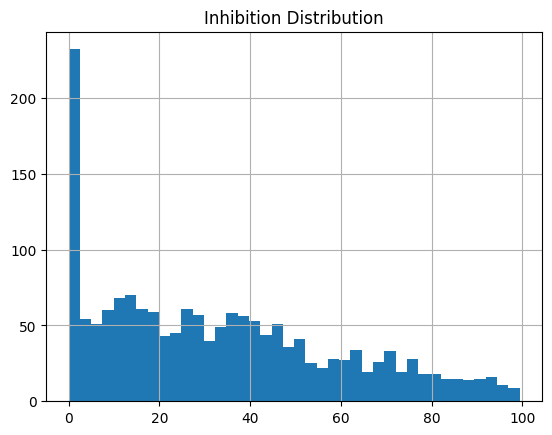

ratio > 70: 0.12492563950029745


In [6]:
plt.figure()
train["Inhibition"].hist(bins=40)
plt.title("Inhibition Distribution")
plt.show()

print("ratio > 70:", (train["Inhibition"] > 70).mean())

SMILES validity check (RDKit)

In [7]:
def is_valid_smiles(s: str) -> bool:
    if pd.isna(s):
        return False
    return Chem.MolFromSmiles(s) is not None

train["smiles_valid"] = train["Canonical_Smiles"].apply(is_valid_smiles)
test["smiles_valid"]  = test["Canonical_Smiles"].apply(is_valid_smiles)

print("train invalid smiles:", (~train["smiles_valid"]).sum())
print("test invalid smiles :", (~test["smiles_valid"]).sum())

train = train[train["smiles_valid"]].drop(columns=["smiles_valid"]).reset_index(drop=True)
test  = test[test["smiles_valid"]].drop(columns=["smiles_valid"]).reset_index(drop=True)

print("train:", train.shape, "test:", test.shape)

train invalid smiles: 0
test invalid smiles : 0
train: (1681, 3) test: (100, 2)


Feature Engineering

In [8]:
def extract_full_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(3006)  # 6 + rdkit descs + morgan

    try:
        mol_wt = Descriptors.MolWt(mol)
        log_p = Descriptors.MolLogP(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        manual_feats = [mol_wt, log_p, h_donors, h_acceptors, tpsa, rot_bonds]
    except:
        manual_feats = [0.0] * 6

    rdkit_descs = []
    for name, func in Descriptors.descList:
        try:
            val = func(mol)
            rdkit_descs.append(float(val) if np.isfinite(val) else 0.0)
        except:
            rdkit_descs.append(0.0)
    rdkit_descs = np.nan_to_num(rdkit_descs)

    morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.concatenate([np.array(manual_feats), np.array(rdkit_descs), np.array(morgan)])


Data Augmentation via SMILES Randomisation (Inhibition > 70%)

In [9]:
def randomize_smiles(smiles, n_aug=3):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(n_aug)]

def augment_high_inhibition_samples(df, threshold=70.0, n_aug=3):
    high_df = df[df['Inhibition'] > threshold].copy()
    aug_rows = []

    for _, row in high_df.iterrows():
        original = row['Canonical_Smiles']
        label = row['Inhibition']
        aug_smiles = randomize_smiles(original, n_aug=n_aug)
        for smi in aug_smiles:
            aug_rows.append({'Canonical_Smiles': smi, 'Inhibition': label})

    aug_df = pd.DataFrame(aug_rows)
    print(f" Total augmented samples: {len(aug_df)}")
    return pd.concat([df, aug_df], ignore_index=True)

Data Preparation

In [10]:
train_aug = augment_high_inhibition_samples(train, threshold=70.0, n_aug=3)
train_aug['Features'] = train_aug['Canonical_Smiles'].apply(extract_full_features)

X = np.stack(train_aug['Features'].values)
y_raw = train_aug['Inhibition'].values

# Stratified KFold용 bin 생성 (이 시점에서!)
train_aug['bin'] = pd.qcut(y_raw, q=5, labels=False, duplicates='drop')
print("bins:", train_aug["bin"].nunique())
train_aug["bin"].value_counts().sort_index()

 총 증강 샘플 수: 630


[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerator
[07:21:07] DEPRECATION WARNING: please use MorganGenerat

bins: 5


[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator
[07:21:33] DEPRECATION WARNING: please use MorganGenerator


,count
bin,
0,463
1,462
2,462
3,464
4,460


Ensemble Training (XGB + Gradient Boosting)

In [13]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds_gb = np.zeros(len(train_aug))
oof_preds_xgb = np.zeros(len(train_aug))
oof_true = np.zeros(len(train_aug))

# t
test = pd.read_csv("test.csv")
test['Features'] = test['Canonical_Smiles'].apply(extract_full_features)
X_test = np.stack(test['Features'].values)
test_pred_gb = np.zeros(len(test))
test_pred_xgb = np.zeros(len(test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, train_aug['bin'])):
    print(f"\n📂 Fold {fold + 1}")

    X_train, X_val = X[tr_idx], X[val_idx]
    y_train, y_val = y_raw[tr_idx], y_raw[val_idx]

    # Gradient Boosting
    model_gb = GradientBoostingRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        max_features="sqrt",
        random_state=42
    )
    model_gb.fit(X_train, y_train)
    pred_gb = model_gb.predict(X_val)
    oof_preds_gb[val_idx] = pred_gb
    test_pred_gb += model_gb.predict(X_test) / n_folds

    #  XGBoost
    model_xgb = XGBRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_val)
    oof_preds_xgb[val_idx] = pred_xgb
    test_pred_xgb += model_xgb.predict(X_test) / n_folds

    # Fold Evaluation
    pred_ensemble = (pred_gb + pred_xgb )/2
    oof_true[val_idx] = y_val

    mse = mean_squared_error(y_val, pred_ensemble)
    rmse = np.sqrt(mse)
    nrmse = rmse / 100
    corr, _ = pearsonr(y_val, pred_ensemble)
    final_score = 0.5 * (1 - min(nrmse, 1)) + 0.5 * corr

    print(f" RMSE       : {rmse:.4f}")
    print(f" NRMSE      : {nrmse:.4f}")
    print(f" Correlation: {corr:.4f}")
    print(f" Fold Score : {final_score:.4f}")

[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerator
[07:24:38] DEPRECATION WARNING: please use MorganGenerat


📂 Fold 1
 RMSE       : 18.0887
 NRMSE      : 0.1809
 Correlation: 0.8312
 Fold Score : 0.8252

📂 Fold 2
 RMSE       : 18.1090
 NRMSE      : 0.1811
 Correlation: 0.8348
 Fold Score : 0.8269

📂 Fold 3
 RMSE       : 18.0246
 NRMSE      : 0.1802
 Correlation: 0.8383
 Fold Score : 0.8290

📂 Fold 4
 RMSE       : 18.9901
 NRMSE      : 0.1899
 Correlation: 0.8152
 Fold Score : 0.8126

📂 Fold 5
 RMSE       : 18.9618
 NRMSE      : 0.1896
 Correlation: 0.8056
 Fold Score : 0.8080


 Evaluation

In [14]:
print("OOF Evaluation:")
oof_ensemble = (oof_preds_gb  + oof_preds_xgb )/2
mse = mean_squared_error(oof_true, oof_ensemble)
rmse = np.sqrt(mse)
nrmse = rmse / 100
corr, _ = pearsonr(oof_true, oof_ensemble)
final_score = 0.5 * (1 - min(nrmse, 1)) + 0.5 * corr

print(f" RMSE       : {rmse:.4f}")
print(f" NRMSE      : {nrmse:.4f}")
print(f" Correlation: {corr:.4f}")
print(f" Final Score: {final_score:.4f}")


OOF Evaluation:
 RMSE       : 18.4400
 NRMSE      : 0.1844
 Correlation: 0.8250
 Final Score: 0.8203
